# Análisis Exploratorio de Datos - Clasificación de Traducciones,

    Este notebook contiene el análisis exploratorio de los datos de traducciones humanas vs. automáticas.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import spacy

%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Cargar el modelo de español
print('Cargando modelo de español...')
nlp = spacy.load('es_core_news_md')
print('Modelo cargado correctamente')

Cargando modelo de español...
Modelo cargado correctamente


In [2]:
# Leer el archivo txt directamente
data = []
labels = []

with open('../data/TRAINING_DATA.txt', 'r', encoding='utf-8') as file:
    for line in file:
        # Separar por tabulación
        label, text = line.strip().split('\t')
        labels.append(int(label))
        data.append(text)

# Crear el DataFrame
df = pd.DataFrame({
    'label': labels,
    'text': data
})

print(f"Dimensiones del dataset: {df.shape}")
print(f"\nPrimeras 5 muestras:")
df.head()

Dimensiones del dataset: (17877, 2)

Primeras 5 muestras:


,label,text
0,1,"Cuando conocí a Janice en 2013 , una familia n..."
1,0,Hwang habló en Sur de este año por Southwest M...
2,1,Usted podría pensar Katy Perry y Robert Pattin...
3,1,Cualquiera que haya volado los cielos del crea...
4,1,"Bueno , este cantante tendrá un LARGO tiempo p..."


## 1. Distribución de Clases

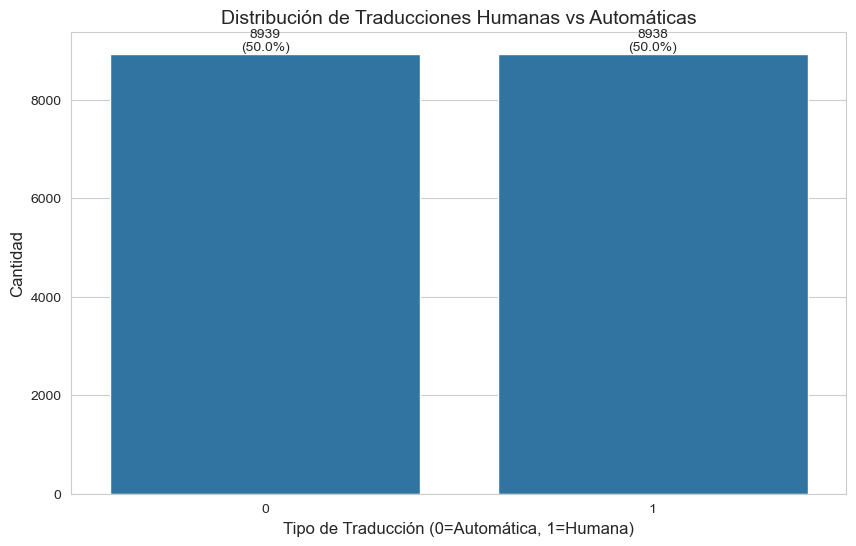


Estadísticas de la distribución de clases:
label
0    50.0
1    50.0
Name: proportion, dtype: float64


In [3]:
# Visualizar distribución de clases
plt.figure(figsize=(10, 6))
class_dist = df['label'].value_counts()
sns.barplot(x=class_dist.index, y=class_dist.values)
plt.title('Distribución de Traducciones Humanas vs Automáticas', fontsize=14)
plt.xlabel('Tipo de Traducción (0=Automática, 1=Humana)', fontsize=12)
plt.ylabel('Cantidad', fontsize=12)

# Añadir porcentajes
total = len(df)
for i, v in enumerate(class_dist.values):
    plt.text(i, v, f'{v}\n({v/total*100:.1f}%)', 
             horizontalalignment='center', 
             verticalalignment='bottom')

plt.show()

print("\nEstadísticas de la distribución de clases:")
print(df['label'].value_counts(normalize=True).round(4) * 100)

## 2. Análisis de Longitud de Textos

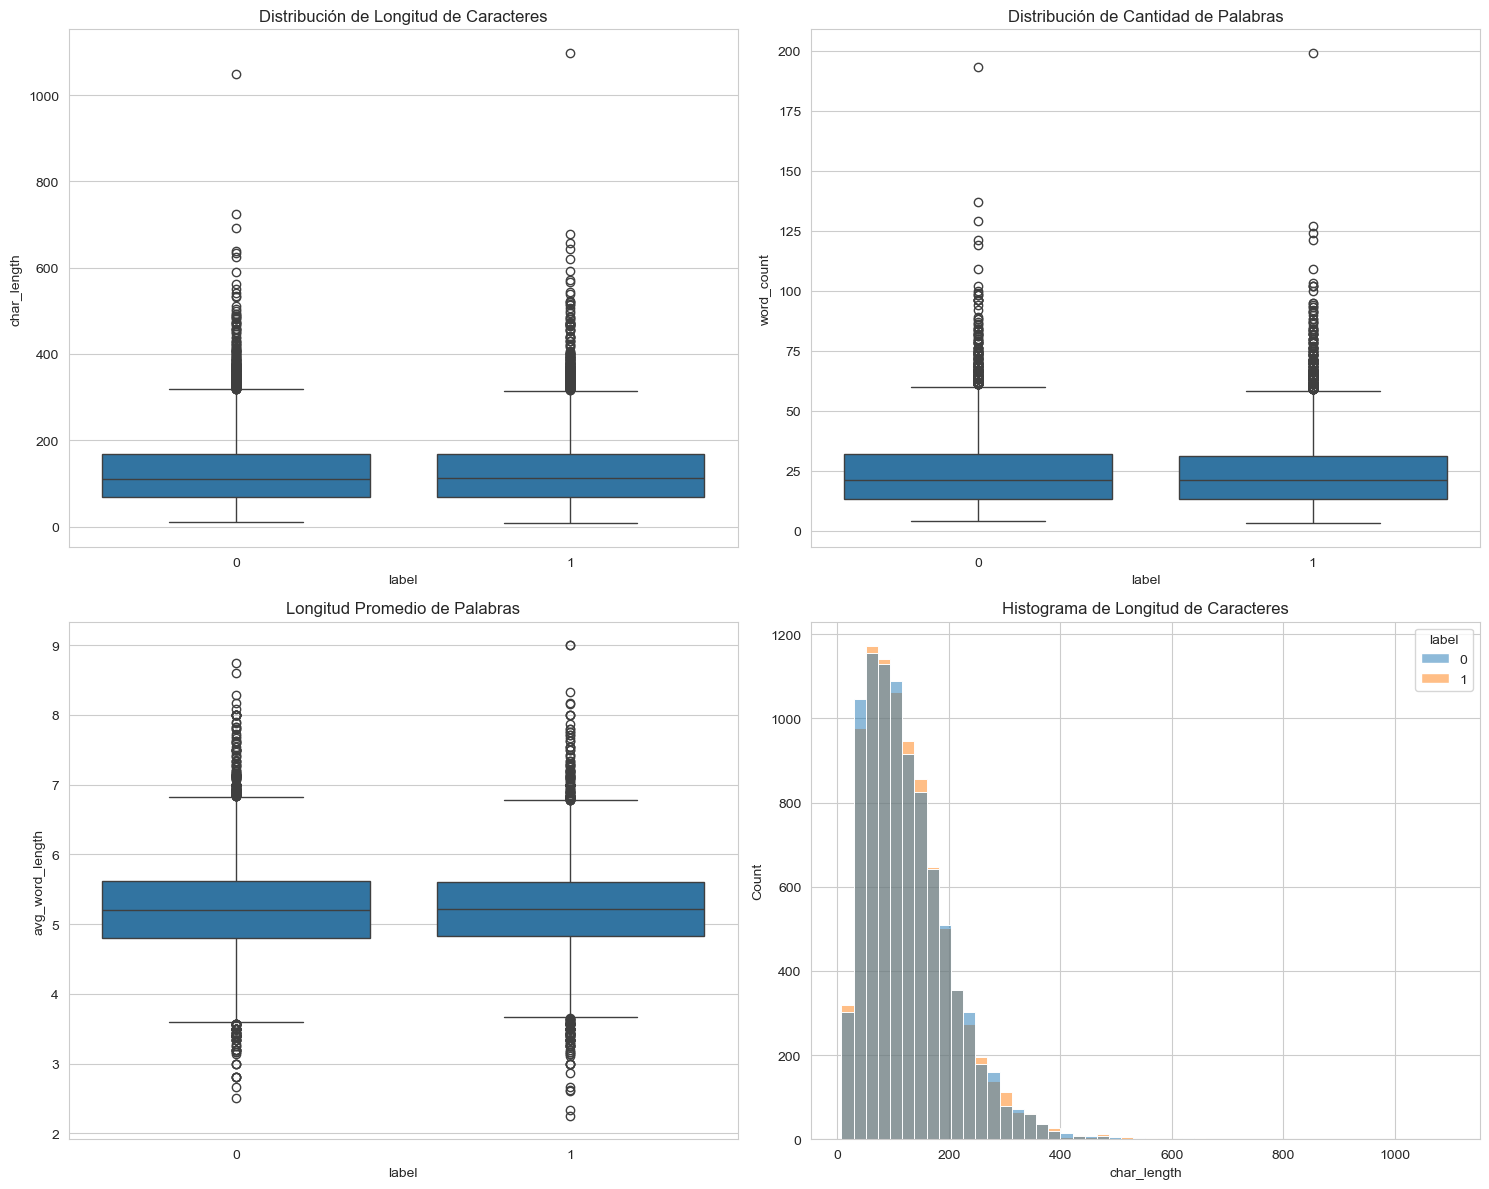


Estadísticas descriptivas por clase:
      char_length                                                           \
            count        mean        std   min   25%    50%    75%     max   
label                                                                        
0          8939.0  126.483164  78.812727  10.0  68.0  111.0  168.0  1049.0   
1          8938.0  126.962967  78.933610   7.0  68.0  111.5  167.0  1098.0   

      word_count             ...              avg_word_length            \
           count       mean  ...   75%    max           count      mean   
label                        ...                                          
0         8939.0  24.031771  ...  32.0  193.0          8939.0  5.215634   
1         8938.0  24.038264  ...  31.0  199.0          8938.0  5.222783   

                                                          
            std   min       25%      50%       75%   max  
label                                                     
0      0.653638  2

In [4]:
# Calcular métricas de longitud
df['char_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()
df['avg_word_length'] = df['char_length'] / df['word_count']

# Visualizar distribuciones
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Longitud de caracteres
sns.boxplot(x='label', y='char_length', data=df, ax=axes[0,0])
axes[0,0].set_title('Distribución de Longitud de Caracteres')

# Cantidad de palabras
sns.boxplot(x='label', y='word_count', data=df, ax=axes[0,1])
axes[0,1].set_title('Distribución de Cantidad de Palabras')

# Longitud promedio de palabras
sns.boxplot(x='label', y='avg_word_length', data=df, ax=axes[1,0])
axes[1,0].set_title('Longitud Promedio de Palabras')

# Histograma de longitud de caracteres
sns.histplot(data=df, x='char_length', hue='label', bins=50, ax=axes[1,1])
axes[1,1].set_title('Histograma de Longitud de Caracteres')

plt.tight_layout()
plt.show()

# Estadísticas descriptivas
print("\nEstadísticas descriptivas por clase:")
print(df.groupby('label')[['char_length', 'word_count', 'avg_word_length']].describe())

## 3. Análisis Linguístico

Analizando 1000 muestras...


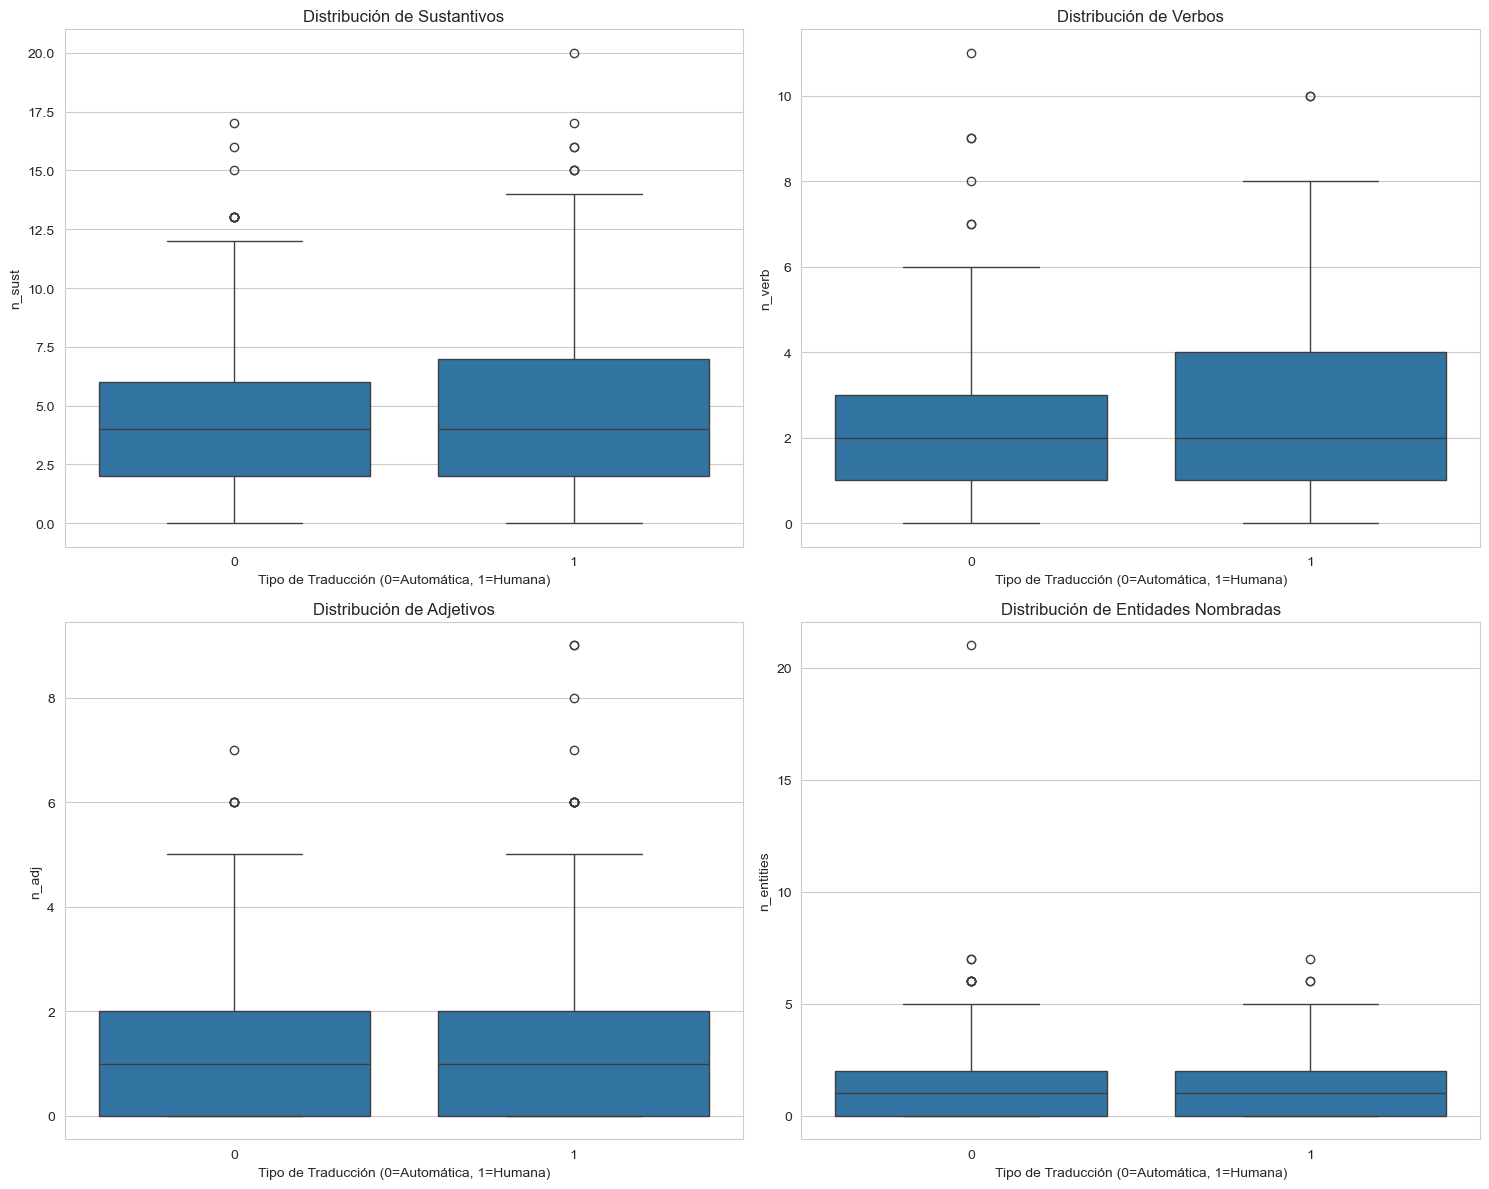


Estadísticas de características lingüísticas por clase:
      n_sust                                               n_verb            \
       count      mean       std  min  25%  50%  75%   max  count      mean   
label                                                                         
0      486.0  4.218107  3.139663  0.0  2.0  4.0  6.0  17.0  486.0  2.271605   
1      514.0  4.597276  3.470184  0.0  2.0  4.0  7.0  20.0  514.0  2.461089   

       ... n_adj      n_entities                                                
       ...   75%  max      count      mean       std  min  25%  50%  75%   max  
label  ...                                                                      
0      ...   2.0  7.0      486.0  1.265432  1.663904  0.0  0.0  1.0  2.0  21.0  
1      ...   2.0  9.0      514.0  1.112840  1.251475  0.0  0.0  1.0  2.0   7.0  

[2 rows x 32 columns]


In [5]:
# Función para extraer características lingüísticas
def get_linguistic_features(text):
    doc = nlp(text)
    return {
        'n_sust': len([token for token in doc if token.pos_ == 'NOUN']),
        'n_verb': len([token for token in doc if token.pos_ == 'VERB']),
        'n_adj': len([token for token in doc if token.pos_ == 'ADJ']),
        'n_entities': len(doc.ents)
    }

# Analizar una muestra del dataset
sample_size = 1000
sample_df = df.sample(sample_size, random_state=42)

# Extraer características
print(f"Analizando {sample_size} muestras...")
features = [get_linguistic_features(text) for text in sample_df['text']]
linguistic_df = pd.DataFrame(features)
linguistic_df['label'] = sample_df['label'].values

# Visualizar características lingüísticas
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
features = ['n_sust', 'n_verb', 'n_adj', 'n_entities']
titles = ['Sustantivos', 'Verbos', 'Adjetivos', 'Entidades Nombradas']

for ax, feat, title in zip(axes.flat, features, titles):
    sns.boxplot(x='label', y=feat, data=linguistic_df, ax=ax)
    ax.set_title(f'Distribución de {title}')
    ax.set_xlabel('Tipo de Traducción (0=Automática, 1=Humana)')

plt.tight_layout()
plt.show()

# Estadísticas descriptivas de características lingüísticas
print("\nEstadísticas de características lingüísticas por clase:")
print(linguistic_df.groupby('label')[features].describe())

## 4. Análisis de Patrones Comunes

Analizando características del texto...


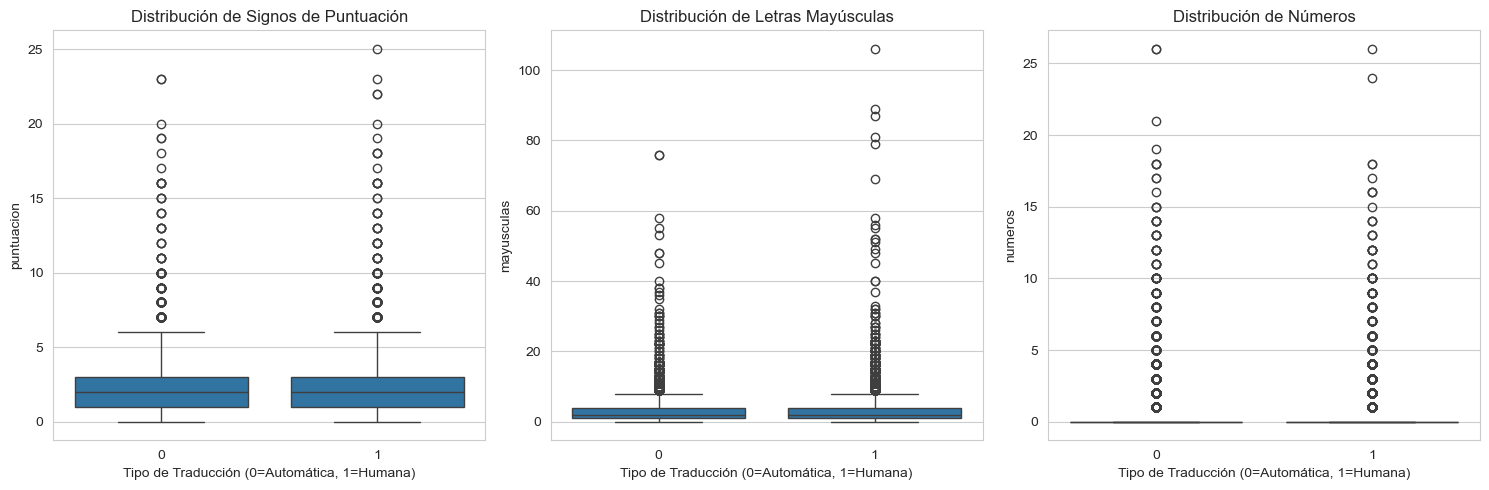


Estadísticas de características por clase:
      puntuacion                                               mayusculas  \
           count      mean       std  min  25%  50%  75%   max      count   
label                                                                       
0         8939.0  2.298356  1.703106  0.0  1.0  2.0  3.0  23.0     8939.0   
1         8938.0  2.386552  1.755997  0.0  1.0  2.0  3.0  25.0     8938.0   

                 ...             numeros                                     \
           mean  ...  75%    max   count      mean       std  min  25%  50%   
label            ...                                                          
0      3.091062  ...  4.0   76.0  8939.0  0.500839  1.624616  0.0  0.0  0.0   
1      3.241217  ...  4.0  106.0  8938.0  0.478183  1.524344  0.0  0.0  0.0   

                  
       75%   max  
label             
0      0.0  26.0  
1      0.0  26.0  

[2 rows x 24 columns]


In [6]:
# Función para extraer características básicas del texto
def get_text_features(text):
    # Contar signos de puntuación
    puntuacion = sum(1 for c in text if c in '.,;:!?¡¿')
    # Contar mayúsculas
    mayusculas = sum(1 for c in text if c.isupper())
    # Contar números
    numeros = sum(1 for c in text if c.isdigit())
    return pd.Series({
        'puntuacion': puntuacion,
        'mayusculas': mayusculas,
        'numeros': numeros
    })

# Extraer características
print("Analizando características del texto...")
text_features = df['text'].apply(get_text_features)
df = pd.concat([df, text_features], axis=1)

# Visualizar características
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
features = ['puntuacion', 'mayusculas', 'numeros']
titles = ['Signos de Puntuación', 'Letras Mayúsculas', 'Números']

for ax, feat, title in zip(axes, features, titles):
    sns.boxplot(x='label', y=feat, data=df, ax=ax)
    ax.set_title(f'Distribución de {title}')
    ax.set_xlabel('Tipo de Traducción (0=Automática, 1=Humana)')

plt.tight_layout()
plt.show()

# Estadísticas de características
print("\nEstadísticas de características por clase:")
print(df.groupby('label')[features].describe())

## Preprocesamiento de datos

In [7]:
import re

# Función de preprocesamiento
def preprocess_text(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar números
    text = re.sub(r'\d+', '', text)
    # Eliminar signos de puntuación
    text = re.sub(r'[^\w\s]', '', text)
    # Eliminar espacios múltiples
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Aplicar preprocesamiento
print("Preprocesando textos...")
df['text_processed'] = df['text'].apply(preprocess_text)
print("Preprocesamiento completado.")

Preprocesando textos...
Preprocesamiento completado.


## 5. Modelado

In [8]:
# Dividir los datos
from sklearn.model_selection import train_test_split

X = df['text_processed']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Dimensiones de los conjuntos de datos:")
print(f"Training: {X_train.shape[0]} muestras")
print(f"Testing: {X_test.shape[0]} muestras")

Dimensiones de los conjuntos de datos:
Training: 14301 muestras
Testing: 3576 muestras


## 6. Vectorización TF-IDF

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorización TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("Dimensiones de los vectores TF-IDF:")
print(f"Training: {X_train_tfidf.shape}")
print(f"Testing: {X_test_tfidf.shape}")

Dimensiones de los vectores TF-IDF:
Training: (14301, 5000)
Testing: (3576, 5000)


## 7. Modelado

In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Lista de modelos a probar
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Linear SVM': LinearSVC(max_iter=1000)
}

# Entrenar y evaluar cada modelo
results = {}

for name, model in models.items():
    print(f"\nEntrenando {name}...")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    
    print(f"\nResultados para {name}:")
    print("\nMatriz de Confusión:")
    print(confusion_matrix(y_test, y_pred))
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))
    
    results[name] = model.score(X_test_tfidf, y_test)

# Mostrar resultados comparativos
print("\nComparación de Modelos (Accuracy):")
for name, score in results.items():
    print(f"{name}: {score:.4f}")


Entrenando Naive Bayes...

Resultados para Naive Bayes:

Matriz de Confusión:
[[ 798  990]
 [1056  732]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.43      0.45      0.44      1788
           1       0.43      0.41      0.42      1788

    accuracy                           0.43      3576
   macro avg       0.43      0.43      0.43      3576
weighted avg       0.43      0.43      0.43      3576


Entrenando Logistic Regression...

Resultados para Logistic Regression:

Matriz de Confusión:
[[847 941]
 [990 798]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.46      0.47      0.47      1788
           1       0.46      0.45      0.45      1788

    accuracy                           0.46      3576
   macro avg       0.46      0.46      0.46      3576
weighted avg       0.46      0.46      0.46      3576


Entrenando Linear SVM...

Resultados para Linear SVM:

Matriz de Co

## 8. Mejora del Preprocesamiento

In [11]:
# Análisis de resultados actuales y mejora del preprocesamiento
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import spacy

# Cargar stopwords en español
spanish_stopwords = set(stopwords.words('spanish'))

# Mejorar la función de preprocesamiento
def preprocess_text_improved(text):
    # Convertir a minúsculas
    text = text.lower()
    
    # Tokenización y eliminación de stopwords
    tokens = text.split()
    tokens = [token for token in tokens if token not in spanish_stopwords]
    
    # Lematización usando spaCy
    doc = nlp(" ".join(tokens))
    lemmatized = [token.lemma_ for token in doc]
    
    # Características específicas de traducción
    n_words = len(tokens)
    avg_word_length = sum(len(word) for word in tokens) / n_words if n_words > 0 else 0
    
    return {
        'text_processed': " ".join(lemmatized),
        'n_words': n_words,
        'avg_word_length': avg_word_length
    }

# Aplicar el preprocesamiento mejorado
print("Aplicando preprocesamiento mejorado...")
processed_features = df['text'].apply(preprocess_text_improved)
df_processed = pd.DataFrame(processed_features.tolist())
df_processed['label'] = df['label']

print("\nDimensiones del dataset procesado:", df_processed.shape)
print("\nPrimeras 5 filas del dataset procesado:")
df_processed.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joseortiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Aplicando preprocesamiento mejorado...

Dimensiones del dataset procesado: (17877, 4)

Primeras 5 filas del dataset procesado:


,text_processed,n_words,avg_word_length,label
0,"conocer janice 2013 , familia necesitar 600 pu...",17,5.529412,1
1,hwang hablar sur año southwest music and media...,16,5.437500,0
2,usted poder pensar katy perry robert pattinson...,17,5.823529,1
3,cualquiera volado cielo creador escuchado acto...,15,6.533333,1
4,"bueno , cantante largo tiempo sentir aún remor...",11,5.454545,1


## 9. Validación Cruzada


Realizando validación cruzada para Naive Bayes...
Scores: [0.3836689  0.39709172 0.3806993  0.38517483 0.40111888]
Media: 0.3896 (+/- 0.0161)

Realizando validación cruzada para Logistic Regression...
Scores: [0.40324385 0.41442953 0.40447552 0.41090909 0.43188811]
Media: 0.4130 (+/- 0.0206)

Realizando validación cruzada para Linear SVM...
Scores: [0.38926174 0.3889821  0.38825175 0.38741259 0.40671329]
Media: 0.3921 (+/- 0.0146)


/var/folders/zf/26z9dj9s4rgb9txx_1j9fkv80000gn/T/ipykernel_36551/2623968798.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([results_cv[name] for name in results_cv.keys()], labels=results_cv.keys())


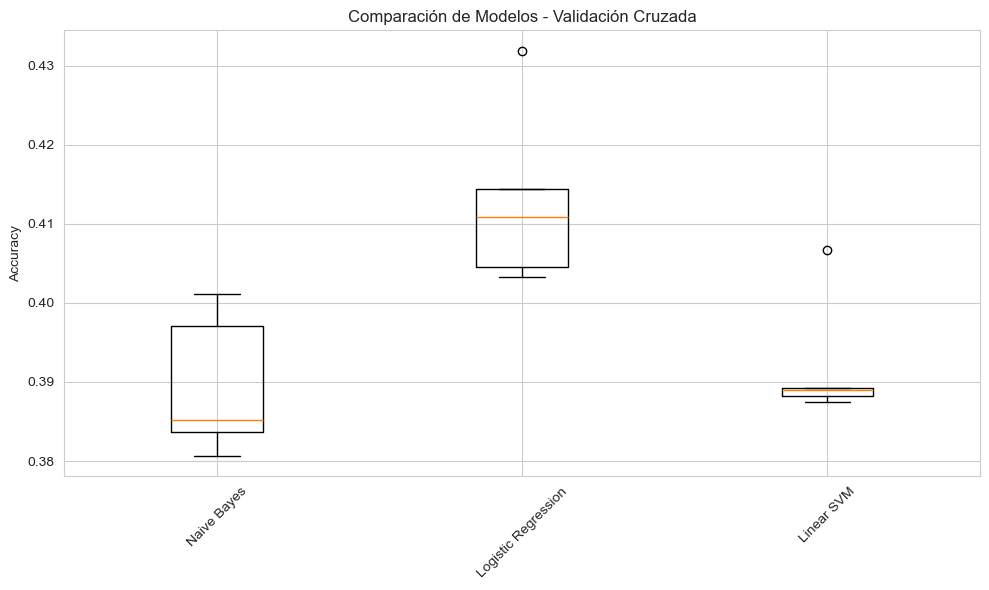

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

# Crear pipelines para cada modelo
pipelines = {
    'Naive Bayes': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000)),
        ('classifier', MultinomialNB())
    ]),
    'Logistic Regression': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000)),
        ('classifier', LogisticRegression(max_iter=1000))
    ]),
    'Linear SVM': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000)),
        ('classifier', LinearSVC(max_iter=1000))
    ])
}

# Realizar validación cruzada
n_folds = 5
results_cv = {}

for name, pipeline in pipelines.items():
    print(f"\nRealizando validación cruzada para {name}...")
    scores = cross_val_score(pipeline, df_processed['text_processed'], 
                           df_processed['label'], cv=n_folds, scoring='accuracy')
    results_cv[name] = scores
    print(f"Scores: {scores}")
    print(f"Media: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

# Visualizar resultados de validación cruzada
plt.figure(figsize=(10, 6))
plt.boxplot([results_cv[name] for name in results_cv.keys()], labels=results_cv.keys())
plt.title('Comparación de Modelos - Validación Cruzada')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 10. Modelo Final

In [13]:
# Crear el pipeline final con las mejores características
final_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2),  # Incluir bigramas
        min_df=2,  # Ignorar términos que aparecen en menos de 2 documentos
        max_df=0.95  # Ignorar términos que aparecen en más del 95% de los documentos
    )),
    ('classifier', LogisticRegression(
        max_iter=1000,
        class_weight='balanced'
    ))
])

# Dividir los datos procesados
X_train, X_test, y_train, y_test = train_test_split(
    df_processed['text_processed'],
    df_processed['label'],
    test_size=0.2,
    random_state=42,
    stratify=df_processed['label']
)

# Entrenar el modelo final
print("Entrenando modelo final...")
final_pipeline.fit(X_train, y_train)

# Evaluar el modelo final
y_pred = final_pipeline.predict(X_test)
print("\nResultados del modelo final:")
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Analizar características más importantes (para Regresión Logística)
feature_names = final_pipeline.named_steps['tfidf'].get_feature_names_out()
coef = final_pipeline.named_steps['classifier'].coef_[0]
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': abs(coef)
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nCaracterísticas más importantes:")
print(feature_importance.head(10))

Entrenando modelo final...

Resultados del modelo final:

Matriz de Confusión:
[[ 744 1044]
 [1020  768]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.42      0.42      0.42      1788
           1       0.42      0.43      0.43      1788

    accuracy                           0.42      3576
   macro avg       0.42      0.42      0.42      3576
weighted avg       0.42      0.42      0.42      3576


Características más importantes:
     feature  importance
4743   usted    3.097841
677      box    2.941976
744     caja    2.710900
2906     mas    2.018418
419    aquel    1.679693
4359    solo    1.624323
4946      yo    1.490364
4970      él    1.475236
515      aun    1.434982
3297     off    1.321163


## 11. Análisis de Clustering

Preparando datos para clustering...


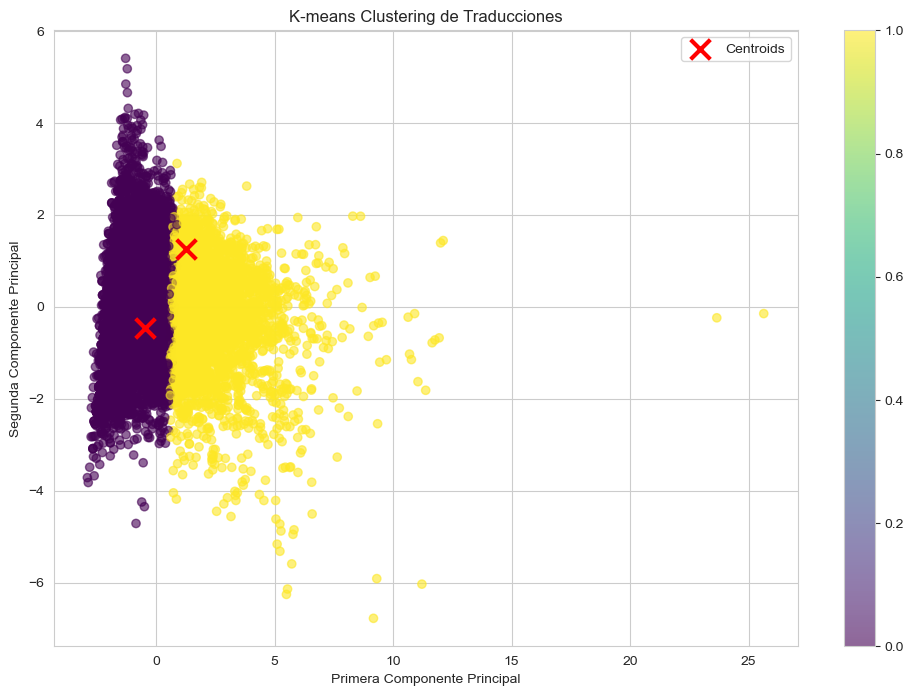


Evaluación de Clustering vs Etiquetas Reales:
Adjusted Rand Index: 0.0000
Adjusted Mutual Information: 0.0000

Medias de características por cluster:
         char_length  word_count  avg_word_length  puntuacion  mayusculas  \
Cluster                                                                     
0          -0.463413   -0.465459        -0.076551   -0.355732   -0.169586   
1           1.238403    1.243871         0.204572    0.950639    0.453192   

          numeros  Label_Real  
Cluster                        
0       -0.164260    0.497348  
1        0.438961    0.506984  

Distribución de etiquetas reales en cada cluster:
Label_Real     0     1
Cluster               
0           6539  6470
1           2400  2468


In [14]:
# ... existing code ...

## 5. Análisis de Clustering

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Preparar características para clustering
print("Preparando datos para clustering...")
features_for_clustering = df[['char_length', 'word_count', 'avg_word_length', 
                            'puntuacion', 'mayusculas', 'numeros']].copy()

# Normalizar características
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_for_clustering)

# Aplicar PCA para visualización
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Aplicar K-means
n_clusters = 2  # Usamos 2 clusters ya que tenemos 2 clases
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features_scaled)

# Visualizar resultados
plt.figure(figsize=(12, 8))
scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1], 
                     c=cluster_labels, cmap='viridis', alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
           color='red', marker='x', s=200, linewidth=3, label='Centroids')
plt.title('K-means Clustering de Traducciones')
plt.xlabel('Primera Componente Principal')
plt.ylabel('Segunda Componente Principal')
plt.legend()
plt.colorbar(scatter)
plt.show()

# Evaluar concordancia entre clusters y etiquetas reales
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

print("\nEvaluación de Clustering vs Etiquetas Reales:")
print(f"Adjusted Rand Index: {adjusted_rand_score(df['label'], cluster_labels):.4f}")
print(f"Adjusted Mutual Information: {adjusted_mutual_info_score(df['label'], cluster_labels):.4f}")

# Analizar características por cluster
cluster_df = pd.DataFrame(features_scaled, columns=features_for_clustering.columns)
cluster_df['Cluster'] = cluster_labels
cluster_df['Label_Real'] = df['label']

print("\nMedias de características por cluster:")
print(cluster_df.groupby('Cluster').mean())

print("\nDistribución de etiquetas reales en cada cluster:")
print(pd.crosstab(cluster_df['Cluster'], cluster_df['Label_Real']))

## 12. Evaluaciones adicionales del clustering

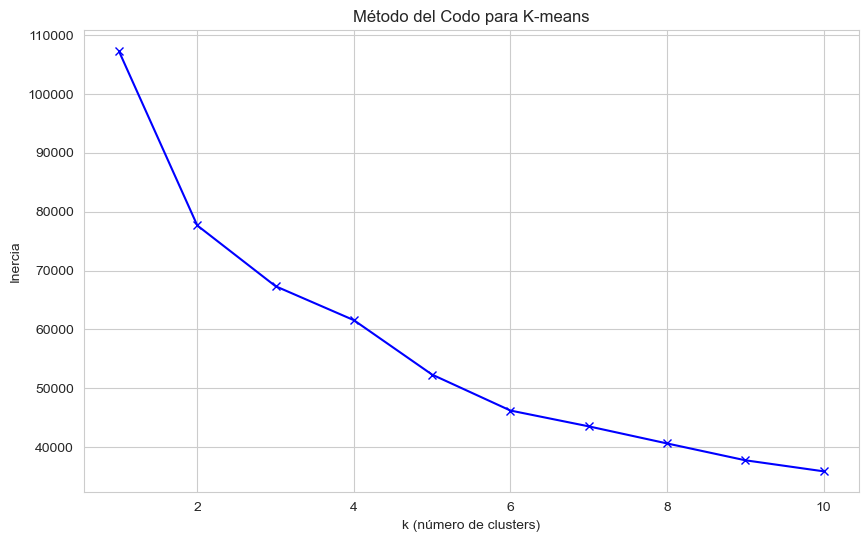


Coeficiente de Silhouette promedio: 0.363


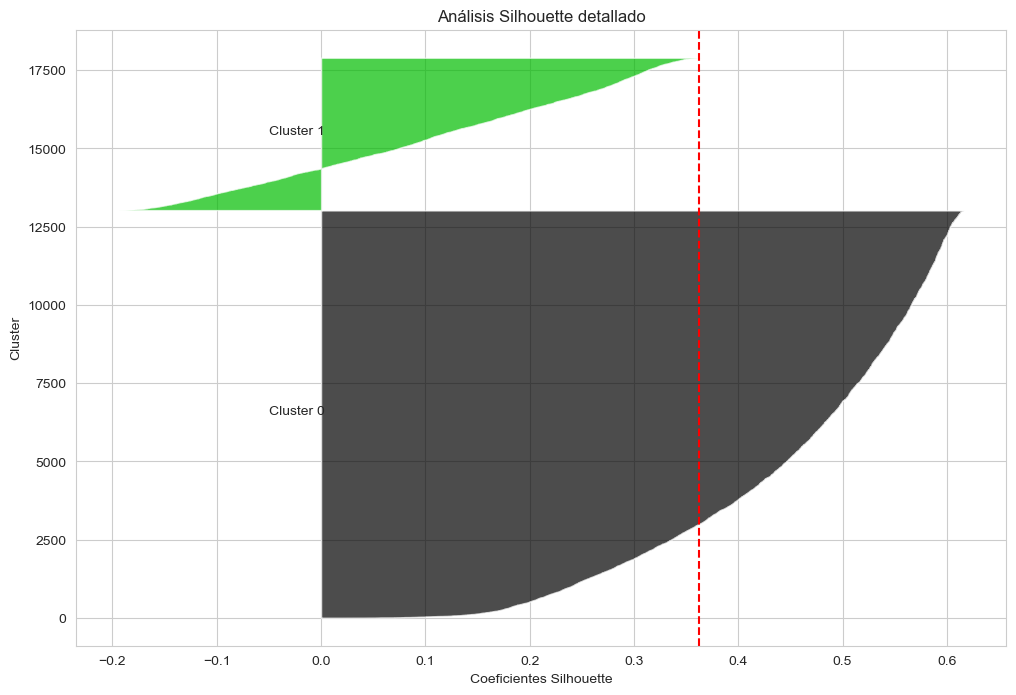


Estabilidad del clustering:
Media de diferencia en silhouette: 0.003 (±0.003)

Análisis estadístico por característica entre clusters:

char_length:
t-statistic: -155.160
p-value: 0.000

word_count:
t-statistic: -156.782
p-value: 0.000

avg_word_length:
t-statistic: -16.864
p-value: 0.000

puntuacion:
t-statistic: -95.570
p-value: 0.000

mayusculas:
t-statistic: -38.577
p-value: 0.000

numeros:
t-statistic: -37.269
p-value: 0.000


In [15]:
# ... existing clustering code ...

## Evaluaciones adicionales del clustering

# 1. Método del codo (Elbow method)
inertias = []
k_range = range(1, 11)

for k in k_range:
    kmeans_test = KMeans(n_clusters=k, random_state=42)
    kmeans_test.fit(features_scaled)
    inertias.append(kmeans_test.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bx-')
plt.xlabel('k (número de clusters)')
plt.ylabel('Inercia')
plt.title('Método del Codo para K-means')
plt.show()

# 2. Coeficiente de Silhouette
from sklearn.metrics import silhouette_score, silhouette_samples
import numpy as np

# Calcular score general
silhouette_avg = silhouette_score(features_scaled, cluster_labels)
print(f"\nCoeficiente de Silhouette promedio: {silhouette_avg:.3f}")

# Visualización detallada de Silhouette
plt.figure(figsize=(12, 8))
sample_silhouette_values = silhouette_samples(features_scaled, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.nipy_spectral(float(i) / n_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, alpha=0.7)
    
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i}')
    y_lower = y_upper + 10

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.title("Análisis Silhouette detallado")
plt.xlabel("Coeficientes Silhouette")
plt.ylabel("Cluster")
plt.show()

# 3. Análisis de estabilidad
from sklearn.model_selection import KFold

def cluster_stability(data, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    stability_scores = []
    
    for train_idx, test_idx in kf.split(data):
        # Entrenar en subset
        kmeans_fold = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans_fold.fit(data[train_idx])
        
        # Predecir en ambos conjuntos
        train_labels = kmeans_fold.predict(data[train_idx])
        test_labels = kmeans_fold.predict(data[test_idx])
        
        # Calcular silhouette para train y test
        train_silhouette = silhouette_score(data[train_idx], train_labels)
        test_silhouette = silhouette_score(data[test_idx], test_labels)
        
        # Calcular diferencia como medida de estabilidad
        stability = abs(train_silhouette - test_silhouette)
        stability_scores.append(stability)
    
    return np.mean(stability_scores), np.std(stability_scores)

stability_mean, stability_std = cluster_stability(features_scaled)
print(f"\nEstabilidad del clustering:")
print(f"Media de diferencia en silhouette: {stability_mean:.3f} (±{stability_std:.3f})")

# 4. Análisis de características por cluster
from scipy import stats

print("\nAnálisis estadístico por característica entre clusters:")
for column in features_for_clustering.columns:
    stat, p_value = stats.ttest_ind(
        features_for_clustering[column][cluster_labels == 0],
        features_for_clustering[column][cluster_labels == 1]
    )
    print(f"\n{column}:")
    print(f"t-statistic: {stat:.3f}")
    print(f"p-value: {p_value:.3f}")

## 13. Análisis de Clustering con Diferentes Features


Evaluando conjunto de características: básico


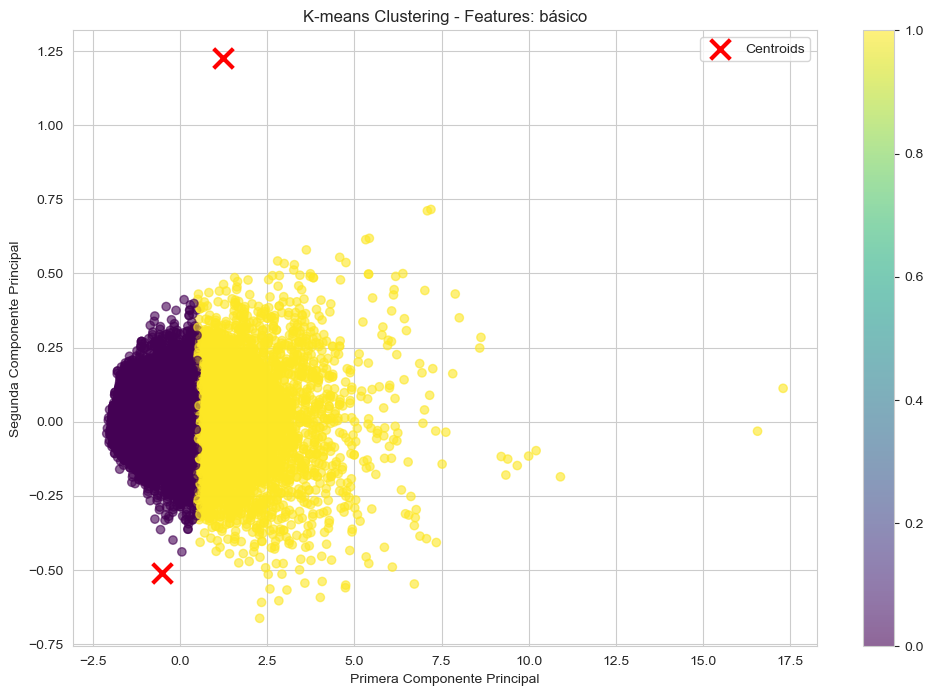

Silhouette Score: 0.593
Adjusted Rand Score: -0.000
Varianza explicada por PCA: 1.000

Matriz de confusión:
label     0     1
row_0            
0      6296  6287
1      2643  2651

Evaluando conjunto de características: longitud


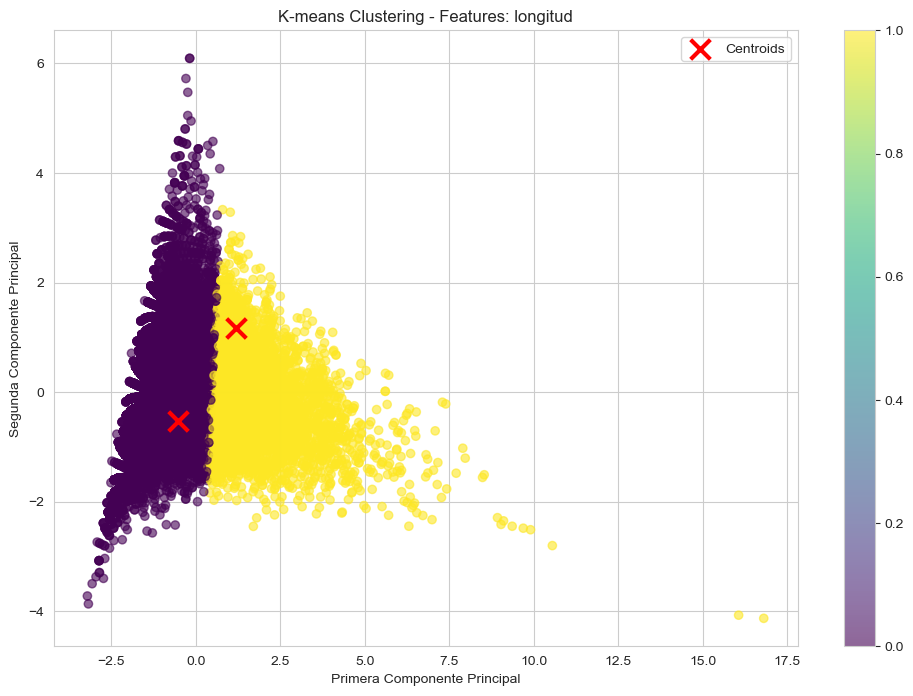

Silhouette Score: 0.413
Adjusted Rand Score: -0.000
Varianza explicada por PCA: 0.998

Matriz de confusión:
label     0     1
row_0            
0      6181  6182
1      2758  2756

Evaluando conjunto de características: puntuación


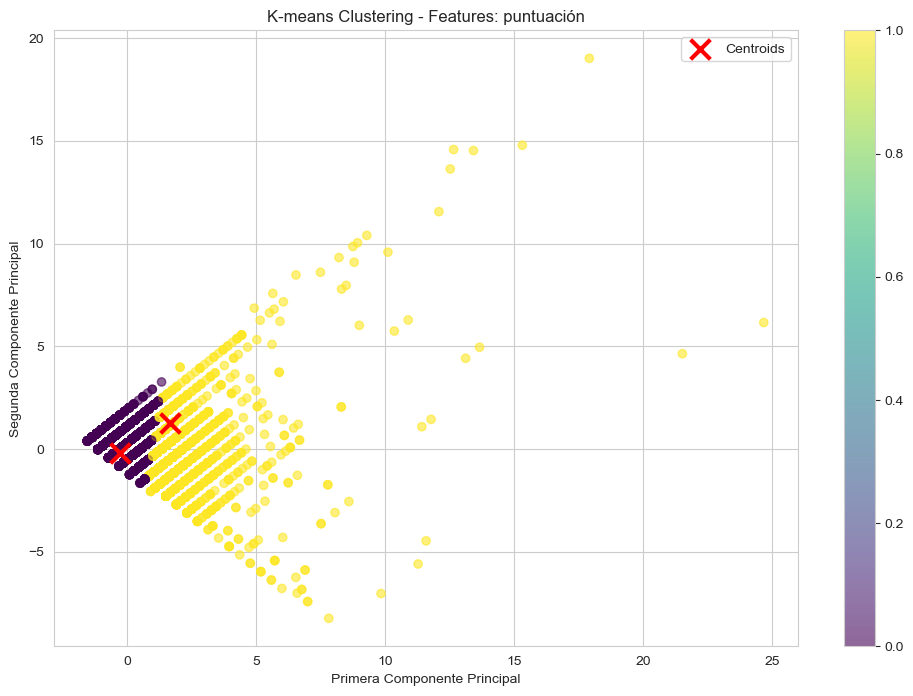

Silhouette Score: 0.599
Adjusted Rand Score: 0.000
Varianza explicada por PCA: 1.000

Matriz de confusión:
label     0     1
row_0            
0      7879  7740
1      1060  1198

Evaluando conjunto de características: completo


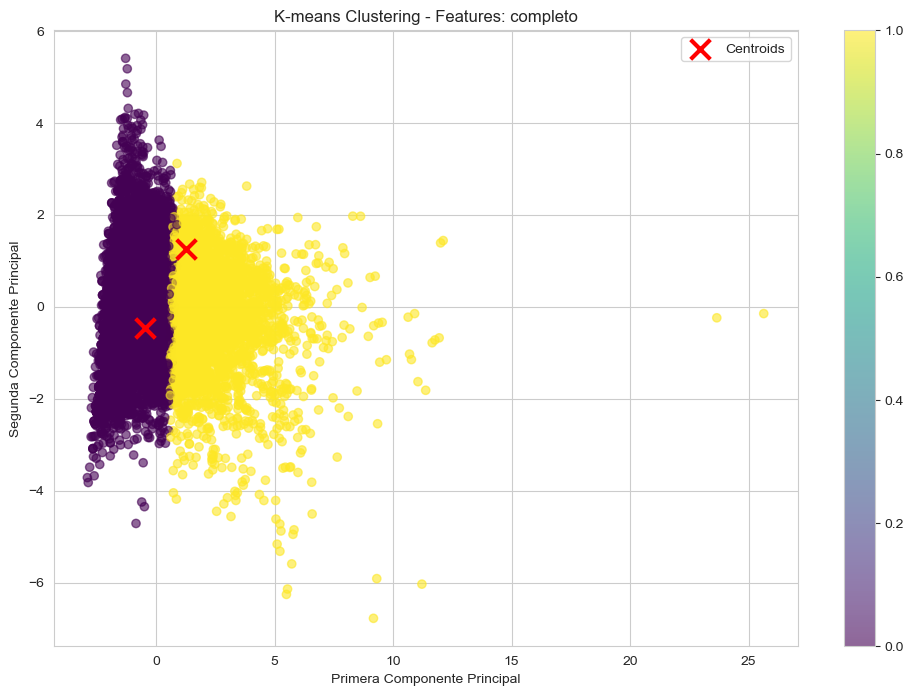

Silhouette Score: 0.363
Adjusted Rand Score: 0.000
Varianza explicada por PCA: 0.626

Matriz de confusión:
label     0     1
row_0            
0      6539  6470
1      2400  2468

Comparación de resultados:
                        básico  longitud  puntuación  completo
Silhouette Score         0.593     0.413       0.599     0.363
Adjusted Rand Score     -0.000    -0.000       0.000     0.000
PCA Variance Explained   1.000     0.998       1.000     0.626


<Figure size 1000x600 with 0 Axes>

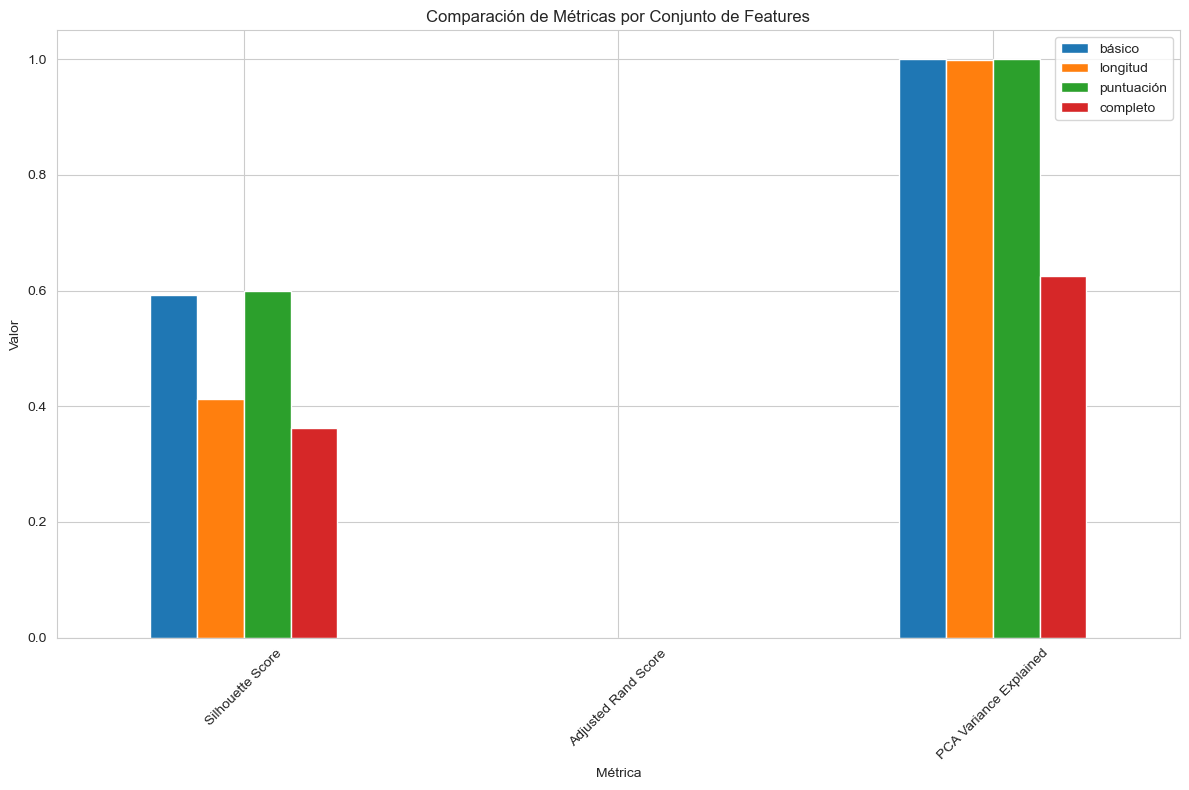


Mejor conjunto de características: puntuación
Silhouette Score: 0.599


In [16]:
## 5. Análisis de Clustering con Diferentes Features

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Definir diferentes conjuntos de características
feature_sets = {
    'básico': ['char_length', 'word_count'],
    'longitud': ['char_length', 'word_count', 'avg_word_length'],
    'puntuación': ['puntuacion', 'mayusculas'],
    'completo': ['char_length', 'word_count', 'avg_word_length', 
                 'puntuacion', 'mayusculas', 'numeros']
}

# Función para evaluar clustering
def evaluate_clustering(features, name):
    # Normalizar
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # PCA para visualización
    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features_scaled)
    
    # K-means
    kmeans = KMeans(n_clusters=2, random_state=42)
    cluster_labels = kmeans.fit_predict(features_scaled)
    
    # Calcular métricas
    silhouette_avg = silhouette_score(features_scaled, cluster_labels)
    rand_score = adjusted_rand_score(df['label'], cluster_labels)
    
    # Visualización
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1], 
                         c=cluster_labels, cmap='viridis', alpha=0.6)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
               color='red', marker='x', s=200, linewidth=3, label='Centroids')
    plt.title(f'K-means Clustering - Features: {name}')
    plt.xlabel('Primera Componente Principal')
    plt.ylabel('Segunda Componente Principal')
    plt.legend()
    plt.colorbar(scatter)
    plt.show()
    
    # Distribución de etiquetas
    confusion = pd.crosstab(cluster_labels, df['label'])
    
    return {
        'silhouette': silhouette_avg,
        'rand_score': rand_score,
        'confusion': confusion,
        'var_ratio': pca.explained_variance_ratio_
    }

# Evaluar cada conjunto de características
results = {}
for name, features in feature_sets.items():
    print(f"\nEvaluando conjunto de características: {name}")
    features_df = df[features].copy()
    results[name] = evaluate_clustering(features_df, name)
    
    print(f"Silhouette Score: {results[name]['silhouette']:.3f}")
    print(f"Adjusted Rand Score: {results[name]['rand_score']:.3f}")
    print(f"Varianza explicada por PCA: {results[name]['var_ratio'].sum():.3f}")
    print("\nMatriz de confusión:")
    print(results[name]['confusion'])

# Comparar resultados
comparison_df = pd.DataFrame({
    name: {
        'Silhouette Score': results[name]['silhouette'],
        'Adjusted Rand Score': results[name]['rand_score'],
        'PCA Variance Explained': results[name]['var_ratio'].sum()
    }
    for name in feature_sets.keys()
}).round(3)

print("\nComparación de resultados:")
print(comparison_df)

# Visualizar comparación
plt.figure(figsize=(10, 6))
comparison_df.plot(kind='bar')
plt.title('Comparación de Métricas por Conjunto de Features')
plt.xlabel('Métrica')
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Identificar el mejor conjunto de características
best_set = max(results.items(), key=lambda x: x[1]['silhouette'])
print(f"\nMejor conjunto de características: {best_set[0]}")
print(f"Silhouette Score: {best_set[1]['silhouette']:.3f}")

## 14. Análisis con DBSCAN

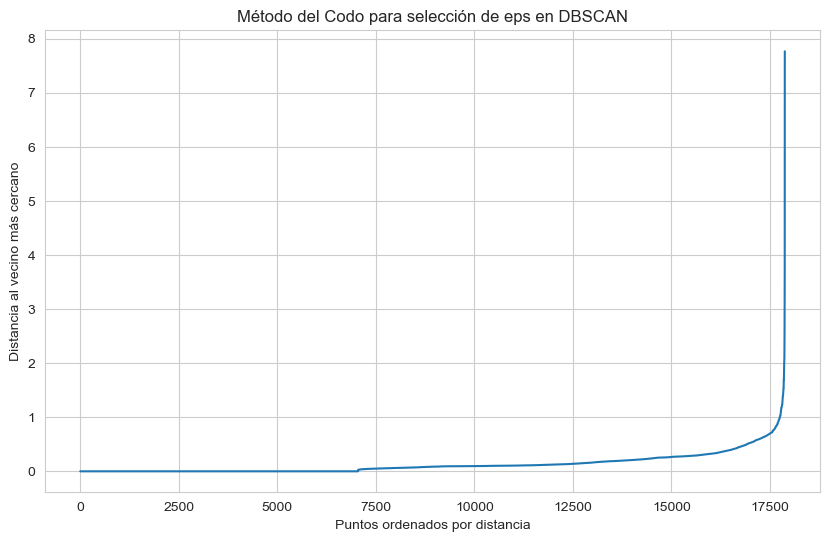


Parámetros: eps=0.3, min_samples=5
Número de clusters: 81
Puntos de ruido: 4500
Silhouette Score: -0.394

Parámetros: eps=0.3, min_samples=10
Número de clusters: 18
Puntos de ruido: 6109
Silhouette Score: -0.309

Parámetros: eps=0.3, min_samples=15
Número de clusters: 10
Puntos de ruido: 7039
Silhouette Score: -0.282

Parámetros: eps=0.5, min_samples=5
Número de clusters: 81
Puntos de ruido: 2497
Silhouette Score: -0.364

Parámetros: eps=0.5, min_samples=10
Número de clusters: 23
Puntos de ruido: 3561
Silhouette Score: -0.167

Parámetros: eps=0.5, min_samples=15
Número de clusters: 12
Puntos de ruido: 4189
Silhouette Score: -0.163

Parámetros: eps=0.7, min_samples=5
Número de clusters: 24
Puntos de ruido: 1074
Silhouette Score: -0.091

Parámetros: eps=0.7, min_samples=10
Número de clusters: 4
Puntos de ruido: 1617
Silhouette Score: 0.170

Parámetros: eps=0.7, min_samples=15
Número de clusters: 1
Puntos de ruido: 1945
Silhouette Score: -1.000

Mejor configuración:
Parámetros: eps=0.7, 

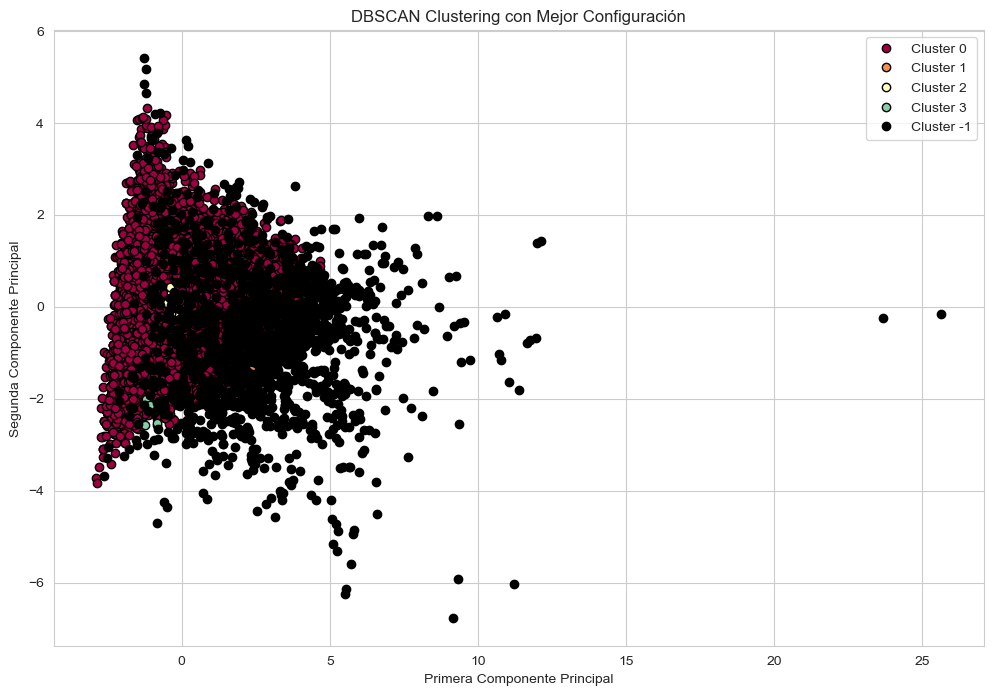


Distribución de etiquetas reales en cada cluster:
label     0     1
row_0            
-1      787   830
 0     8137  8091
 1        5     7
 2        3     7
 3        7     3

Análisis de características por cluster:

Cluster 0:
       char_length  word_count  avg_word_length  puntuacion  mayusculas  \
count    16228.000   16228.000        16228.000   16228.000   16228.000   
mean        -0.118      -0.120           -0.012      -0.138      -0.130   
std          0.842       0.840            0.995       0.718       0.594   
min         -1.518      -1.461           -4.586      -1.354      -0.804   
25%         -0.783      -0.767           -0.647      -0.776      -0.550   
50%         -0.263      -0.280           -0.030      -0.198      -0.296   
75%          0.384       0.414            0.588       0.380       0.212   
max          3.275       3.610            4.810       3.848       3.513   

         numeros  Cluster  
count  16228.000  16228.0  
mean      -0.174      0.0  
std      

In [17]:
## 6. Análisis con DBSCAN

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Preparar los datos
features_for_clustering = df[['char_length', 'word_count', 'avg_word_length', 
                            'puntuacion', 'mayusculas', 'numeros']].copy()
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_for_clustering)

# Encontrar el mejor eps usando el método del codo con k-nearest neighbors
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(features_scaled)
distances, indices = neighbors_fit.kneighbors(features_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:,1]  # Get the distance to the 2nd nearest neighbor

plt.figure(figsize=(10, 6))
plt.plot(range(len(distances)), distances)
plt.title('Método del Codo para selección de eps en DBSCAN')
plt.xlabel('Puntos ordenados por distancia')
plt.ylabel('Distancia al vecino más cercano')
plt.show()

# Probar diferentes combinaciones de eps y min_samples
eps_range = [0.3, 0.5, 0.7]
min_samples_range = [5, 10, 15]

results_dbscan = {}

for eps in eps_range:
    for min_samples in min_samples_range:
        # Aplicar DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(features_scaled)
        
        # Calcular métricas solo si hay más de un cluster
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        
        if n_clusters > 1:
            silhouette_avg = silhouette_score(features_scaled, cluster_labels)
        else:
            silhouette_avg = -1
            
        # Guardar resultados
        key = f'eps={eps}, min_samples={min_samples}'
        results_dbscan[key] = {
            'n_clusters': n_clusters,
            'n_noise': list(cluster_labels).count(-1),
            'silhouette': silhouette_avg,
            'labels': cluster_labels
        }
        
        print(f"\nParámetros: {key}")
        print(f"Número de clusters: {n_clusters}")
        print(f"Puntos de ruido: {list(cluster_labels).count(-1)}")
        print(f"Silhouette Score: {silhouette_avg:.3f}")

# Encontrar la mejor configuración
best_config = max(results_dbscan.items(), 
                 key=lambda x: x[1]['silhouette'] if x[1]['n_clusters'] > 1 else -float('inf'))

print("\nMejor configuración:")
print(f"Parámetros: {best_config[0]}")
print(f"Silhouette Score: {best_config[1]['silhouette']:.3f}")

# Visualizar el mejor resultado
best_labels = best_config[1]['labels']

# PCA para visualización
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Visualizar clusters
plt.figure(figsize=(12, 8))
unique_labels = set(best_labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Puntos de ruido en negro
        col = 'black'
    
    class_member_mask = (best_labels == k)
    xy = features_pca[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6, label=f'Cluster {k}')

plt.title('DBSCAN Clustering con Mejor Configuración')
plt.xlabel('Primera Componente Principal')
plt.ylabel('Segunda Componente Principal')
plt.legend()
plt.show()

# Análisis de clusters vs etiquetas reales
print("\nDistribución de etiquetas reales en cada cluster:")
print(pd.crosstab(best_labels, df['label']))

# Análisis estadístico de características por cluster
print("\nAnálisis de características por cluster:")
cluster_df = pd.DataFrame(features_scaled, columns=features_for_clustering.columns)
cluster_df['Cluster'] = best_labels

for cluster in unique_labels:
    print(f"\nCluster {cluster}:")
    print(cluster_df[cluster_df['Cluster'] == cluster].describe().round(3))

# Comparación con K-means
kmeans = KMeans(n_clusters=len(unique_labels)-1 if -1 in unique_labels else len(unique_labels), 
                random_state=42)
kmeans_labels = kmeans.fit_predict(features_scaled)

print("\nComparación con K-means:")
print(f"Silhouette Score K-means: {silhouette_score(features_scaled, kmeans_labels):.3f}")
print(f"Silhouette Score DBSCAN: {best_config[1]['silhouette']:.3f}")

## 15. Análisis con diferentes n-grams


Evaluando unigrams ((1, 1))...
Accuracy promedio: 0.429 (±0.002)

Top 10 n-grams más importantes:
          ngram  importance
16158        tu    3.288162
2089        box    3.267199
16366     usted    3.100473
2324       caja    2.960366
16180       tus    2.805270
13024    puedes    2.458676
14973      solo    2.440756
4031       cual    2.434050
2789   chchecha    2.420647
7857       haya    2.267011

Evaluando bigrams ((2, 2))...
Accuracy promedio: 0.343 (±0.006)

Top 10 n-grams más importantes:
             ngram  importance
6170   chchecha un    2.326454
28854      la caja    2.112525
44366       que es    1.850326
11809        de la    1.589649
23304     fuera de    1.587532
58293        yo no    1.582166
45028    que usted    1.575693
12902        de tu    1.549032
18500        en tu    1.541331
10727       de box    1.427065

Evaluando trigrams ((3, 3))...
Accuracy promedio: 0.337 (±0.007)

Top 10 n-grams más importantes:
                     ngram  importance
6325   chchecha 

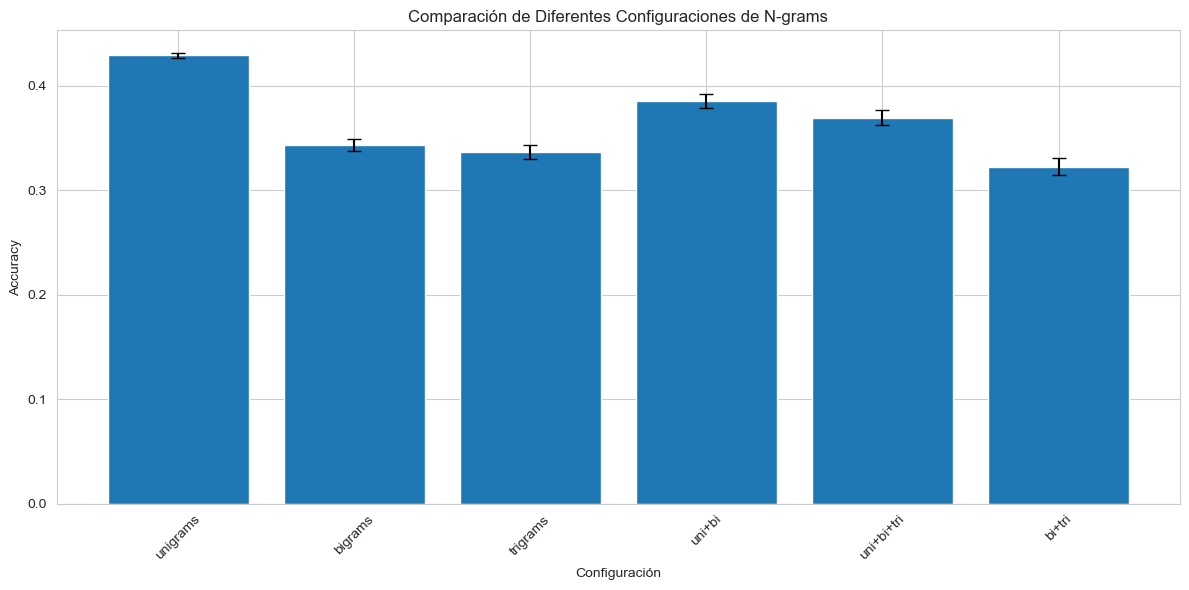


Mejor configuración: unigrams
Accuracy: 0.429 (±0.002)

Reporte de clasificación con la mejor configuración:
              precision    recall  f1-score   support

           0       0.42      0.44      0.43      1751
           1       0.44      0.43      0.44      1825

    accuracy                           0.43      3576
   macro avg       0.43      0.43      0.43      3576
weighted avg       0.43      0.43      0.43      3576


Ejemplos de clasificaciones incorrectas:

Texto: esto hubiera sido mejor para el público de manera que luego pueden procesar oh ted lloró...
Etiqueta verdadera: 1
Predicción: 0

Texto: vea la reacción de katy aquí...
Etiqueta verdadera: 1
Predicción: 0

Texto: jefe de educación christie koehler de mozilla no opinó sobre la idoneidad de eich como ceo pero expr...
Etiqueta verdadera: 1
Predicción: 0

Texto: sería extraño hacer directamente un tiro pov...
Etiqueta verdadera: 1
Predicción: 0

Texto: cuando soy optimista creo que a lo mejor soy una flor tardía.

In [19]:
## Análisis con diferentes n-grams

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
import numpy as np

# Definir diferentes configuraciones de n-grams
ngram_configs = {
    'unigrams': (1, 1),
    'bigrams': (2, 2),
    'trigrams': (3, 3),
    'uni+bi': (1, 2),
    'uni+bi+tri': (1, 3),
    'bi+tri': (2, 3)
}

# Función para crear y evaluar pipeline con diferentes n-grams
def evaluate_ngrams(X, y, ngram_range, model):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(
            ngram_range=ngram_range,
            min_df=2,  # Ignorar términos que aparecen en menos de 2 documentos
            max_df=0.95  # Ignorar términos que aparecen en más del 95% de documentos
        )),
        ('classifier', model)
    ])
    
    # Cross-validation
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
    
    # Entrenar en todo el conjunto para ver ejemplos
    pipeline.fit(X, y)
    
    # Obtener los n-grams más importantes
    feature_names = pipeline.named_steps['tfidf'].get_feature_names_out()
    if hasattr(pipeline.named_steps['classifier'], 'coef_'):
        importances = np.abs(pipeline.named_steps['classifier'].coef_[0])
    else:
        importances = np.zeros(len(feature_names))
    
    # Top n-grams
    top_ngrams = pd.DataFrame({
        'ngram': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False).head(10)
    
    return {
        'mean_score': scores.mean(),
        'std_score': scores.std(),
        'top_ngrams': top_ngrams
    }

# Evaluar cada configuración
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)

results = {}
for name, ngram_range in ngram_configs.items():
    print(f"\nEvaluando {name} ({ngram_range})...")
    results[name] = evaluate_ngrams(df['text_processed'], df['label'], ngram_range, model)
    print(f"Accuracy promedio: {results[name]['mean_score']:.3f} (±{results[name]['std_score']:.3f})")
    print("\nTop 10 n-grams más importantes:")
    print(results[name]['top_ngrams'])

# Visualizar comparación de resultados
plt.figure(figsize=(12, 6))
means = [results[name]['mean_score'] for name in ngram_configs]
stds = [results[name]['std_score'] for name in ngram_configs]

plt.bar(ngram_configs.keys(), means, yerr=stds, capsize=5)
plt.title('Comparación de Diferentes Configuraciones de N-grams')
plt.xlabel('Configuración')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Análisis detallado de la mejor configuración
best_config = max(results.items(), key=lambda x: x[1]['mean_score'])
print(f"\nMejor configuración: {best_config[0]}")
print(f"Accuracy: {best_config[1]['mean_score']:.3f} (±{best_config[1]['std_score']:.3f})")

# Pipeline final con la mejor configuración
final_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        ngram_range=ngram_configs[best_config[0]],
        min_df=2,
        max_df=0.95
    )),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Análisis de errores con la mejor configuración
X_train, X_test, y_train, y_test = train_test_split(
    df['text_processed'], df['label'], test_size=0.2, random_state=42
)

final_pipeline.fit(X_train, y_train)
y_pred = final_pipeline.predict(X_test)

print("\nReporte de clasificación con la mejor configuración:")
print(classification_report(y_test, y_pred))

# Análisis de ejemplos mal clasificados
errors = X_test[y_pred != y_test]
true_labels = y_test[y_pred != y_test]
pred_labels = y_pred[y_pred != y_test]

print("\nEjemplos de clasificaciones incorrectas:")
for text, true_label, pred_label in zip(errors[:5], true_labels[:5], pred_labels[:5]):
    print(f"\nTexto: {text[:100]}...")
    print(f"Etiqueta verdadera: {true_label}")
    print(f"Predicción: {pred_label}")

## 16. Modelos de Transformadores

In [23]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm  # Para barras de progreso
import time

def train_evaluate_transformer(model_name, X_train, X_test, y_train, y_test):
    print(f"\nIniciando proceso para {model_name}")
    
    try:
        # Cargar tokenizer y modelo
        print("Cargando tokenizer y modelo...")
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
        
        # Tokenizar datos
        print("Tokenizando datos...")
        train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
        test_encodings = tokenizer(list(X_test), truncation=True, padding=True)
        
        # Convertir a tensores
        print("Preparando datasets...")
        train_dataset = TensorDataset(
            torch.tensor(train_encodings['input_ids']),
            torch.tensor(train_encodings['attention_mask']),
            torch.tensor(y_train.values)
        )
        test_dataset = TensorDataset(
            torch.tensor(test_encodings['input_ids']),
            torch.tensor(test_encodings['attention_mask']),
            torch.tensor(y_test.values)
        )
        
        # Crear dataloaders
        train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=8)
        
        # Configurar entrenamiento
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Usando dispositivo: {device}")
        model.to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
        
        # Entrenamiento
        print("\nIniciando entrenamiento...")
        model.train()
        for epoch in range(3):
            start_time = time.time()
            total_loss = 0
            batch_count = 0
            
            # Barra de progreso para los batches
            progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/3')
            for batch in progress_bar:
                optimizer.zero_grad()
                input_ids = batch[0].to(device)
                attention_mask = batch[1].to(device)
                labels = batch[2].to(device)
                
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                total_loss += loss.item()
                batch_count += 1
                
                loss.backward()
                optimizer.step()
                
                # Actualizar la barra de progreso
                progress_bar.set_postfix({'loss': f'{total_loss/batch_count:.4f}'})
            
            epoch_time = time.time() - start_time
            print(f'Epoch {epoch+1} completada en {epoch_time:.2f} segundos')
            print(f'Loss promedio: {total_loss/batch_count:.4f}')
        
        # Evaluación
        print("\nIniciando evaluación...")
        model.eval()
        predictions = []
        actual_labels = []
        
        with torch.no_grad():
            for batch in tqdm(test_loader, desc='Evaluando'):
                input_ids = batch[0].to(device)
                attention_mask = batch[1].to(device)
                labels = batch[2]
                
                outputs = model(input_ids, attention_mask=attention_mask)
                preds = torch.argmax(outputs.logits, dim=1)
                predictions.extend(preds.cpu().numpy())
                actual_labels.extend(labels.numpy())
        
        # Calcular métricas
        accuracy = accuracy_score(actual_labels, predictions)
        report = classification_report(actual_labels, predictions)
        
        print(f"\nEvaluación completada:")
        print(f"Accuracy: {accuracy:.3f}")
        
        return {
            'accuracy': accuracy,
            'report': report,
            'predictions': predictions
        }
    
    except Exception as e:
        print(f"\nError durante el proceso:")
        print(f"Tipo de error: {type(e).__name__}")
        print(f"Descripción: {str(e)}")
        return None

# Dividir datos
print("Preparando datos...")
X_train, X_test, y_train, y_test = train_test_split(
    df['text_processed'], df['label'], 
    test_size=0.2, random_state=42
)

# Probar modelos
model_configs = {
    'BETO': 'dccuchile/bert-base-spanish-wwm-uncased',
    'RoBERTa-Spanish': 'BSC-TeMU/roberta-base-bne'
}

results = {}
for name, model_path in model_configs.items():
    print(f"\n{'='*50}")
    print(f"Iniciando entrenamiento de {name}")
    print(f"{'='*50}")
    
    results[name] = train_evaluate_transformer(
        model_path, X_train, X_test, y_train, y_test
    )
    
    if results[name] is not None:
        print(f"\nResultados finales para {name}:")
        print(f"Accuracy: {results[name]['accuracy']:.3f}")
        print("\nReporte de clasificación:")
        print(results[name]['report'])

# Visualizar comparación si hay resultados
if any(results.values()):
    plt.figure(figsize=(10, 6))
    accuracies = [result['accuracy'] for result in results.values() if result is not None]
    valid_models = [name for name, result in results.items() if result is not None]
    
    plt.bar(valid_models, accuracies)
    plt.title('Comparación de Accuracy entre Transformers')
    plt.xlabel('Modelo')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Preparando datos...

Iniciando entrenamiento de BETO

Iniciando proceso para dccuchile/bert-base-spanish-wwm-uncased
Cargando tokenizer y modelo...


Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuc

Tokenizando datos...
Preparando datasets...
Usando dispositivo: cpu

Iniciando entrenamiento...


Epoch 1/3:   1%|▏         | 26/1788 [00:46<49:31,  1.69s/it, loss=0.7348] 